<div style='text-align: center;'>
<img src="images/math60082-banner.png" alt="image" width="80%" height="auto">
</div>

# Lab Class - Week 6
## Dr P. V. Johnson
## Department of Mathematics

# This Week

- Demo 6.1 Stochastic Volatility
- Demo 6.2 Path Dependent Options

# Demo 6.1: Stochastic Volatility

A popular model for option pricing is the Heston model, named after its academic creator. As motivation for this model, it is often stated that ``volatility (or variance of stock prices) is stochastic'', and the starting point is to write down a multifactor model for stock prices. However the main reason for the popularity of the model is that it has analytic solutions (for the probability density function) and provides a better match to market prices than other competing models. It does not necessarily provide a better model of stock prices than the standard geometric Brownian motion.

Let us now describe the model itself. Under the risk nuetral measure, a stock paying dividends at the continuous rate $q$ moves according to the following SDEs:
$$
dS = (r-q) S dt + \sqrt{\nu} S dW_1\\
d\nu = \kappa(\theta - \nu) dt + \xi \sqrt{\nu} dW_2
$$
where $W_1$ and $W_2$ are correlated Weiner processes with linear correlation parameter $\rho$. The parameters $\kappa$, $\theta$ and $\xi$ are risk adjusted positive constants, and $r$ is the risk free rate.

Unfortunately this model does not have an analytic solution in the risk neutral measure, so we will need to simulate the entire path to get option prices.
First, we consider that time is split into $K$ equally spaced periods of time, such that
$$
\Delta t = \frac{T}{K} ,\quad \text{ and }\quad t^k = k\Delta t.
$$


Then we can create a random paths using an Euler scheme on both SDEs
$$S^{k+1} = S^{k}+(r-q)S^{k}\Delta t + \sqrt{\nu^k}S^{k} \Delta W_1$$ 
$$\nu^{k+1} = \nu^k +\kappa(\theta-\nu^k)\Delta t + \xi \sqrt{\nu^k} \Delta W_2$$ 
To generate a pair $(\Delta W_1,\Delta W_2)$ of normally distributed, linear correlated random numbers, we use
$$
$$
$$
\Delta W_2 = \sqrt{\Delta t}\rho\phi_1 + \sqrt{\Delta t}\sqrt{(1-\rho^2)}\phi_2 
$$
where $\phi_1\sim N(0,1)$ and $\phi_2\sim N(0,1)$ are independent uncorrelated draws from the standard normal distribution. Note that in python you can sample from the multivariate normal distribution as well to get $(\Delta W_1,\Delta W_2)$ directly.

In [1]:
import matplotlib.pyplot as plt
import numpy
rng = numpy.random.default_rng(seed=0)

Now create some parameters for our problem. 

In [2]:
# stock parameters
S_0 = 98.31 # initial stick price
q = 0.01 # dividend yield

# call option contract parameters
X = 100 # strike price
T = 1.0 # time to expiry

# market parameters
r = 0.03 # risk free interest rate

# model parameters
kappa_nu = 1.5 # mean reversion parameter
theta_nu = 0.06 # long term value of the variance
nu_0 = 0.04 # initial variance
xi_nu = 0.4 # so called volatility of volatility
rho = -0.5 # correlation

For the numerical problem, we start with a relative smallish number of paths to keep the computations quick.

In [3]:
N=1000
K=200

First generate numbers from standard normals, in this case we create an $N\times K$ matrix of $\phi$ values, to store the $K$ random numbers for each of the $N$ paths.

In [4]:

dt = T/K

phi1 = rng.normal( 0.0 , 1.0 , size = (N,K) )
phi2 = rng.normal( 0.0 , 1.0 , size = (N,K) )

dW1 = numpy.zeros((N,K))
dW2 = numpy.zeros((N,K))
for i in range(0,N):
    for k in range(0,K):
        dW1[i][k] = numpy.sqrt(dt)*phi1[i][k]
        dW2[i][k] = rho*numpy.sqrt(dt)*phi1[i][k] + numpy.sqrt(dt*(1-rho*rho))*phi2[i][k]

Now plot the values out, we just plot the first column. If the $\rho>0$, we should see the results cluster around the line $y=x$, whereas if $\rho<0$ they should cluster around $y=-x$.

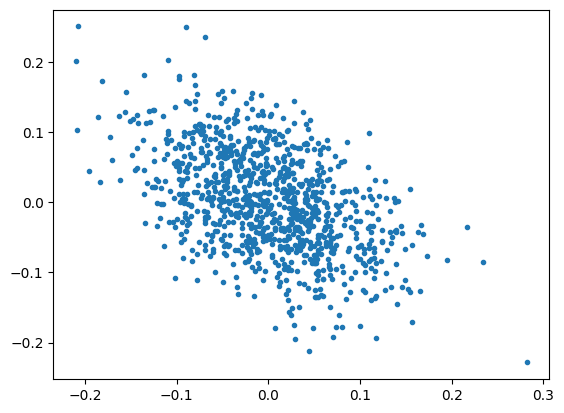

In [5]:
plt.plot( dW1.T [0] , dW2.T[0] ,'.')

Next use a multivariate normal generator function. This requires a mean and covariance matrix to work. To directly calculate $dW_i$, we can use the mean 
$$
E[dW_1] = 0 , \quad\text{ and } \quad E[dW_2]=0
$$
and covariance
$$
\text{Cov}(dW_1,dW_2) = \left( \begin{array}{cc} 
dt & \rho dt\\ 
\rho dt &  dt 
\end{array}
\right) .
$$

Note that in the call to the multivariate normal, we use the transpose `(:::).T` to get the results into the variables `dW1` and `dW2`. As a result, we reverse the size call `size=(K,N)` to get the matrix in the correct format.

In [6]:
dW1 , dW2 = rng.multivariate_normal( [ 0.0 , 0.0 ] , [ [ dt , rho*dt ] , [ rho*dt , dt] ] , size = (K,N) ).T

You should notice that the call to this function is significantly quicker than the other one, even though the results look the same if we plot them out.

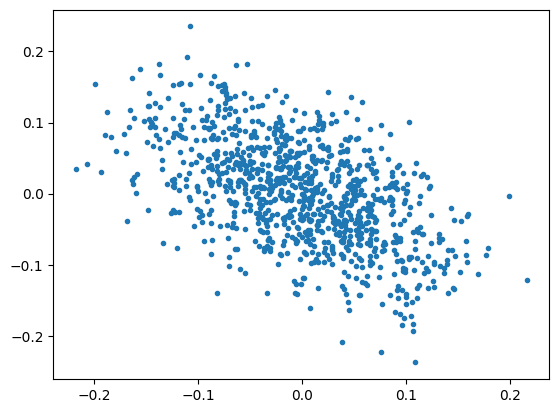

In [7]:
plt.plot( dW1.T[0] , dW2.T[0] ,'.')

First let us create a path and see what it look like.

Text(0.5, 1.0, 'sigma_t')

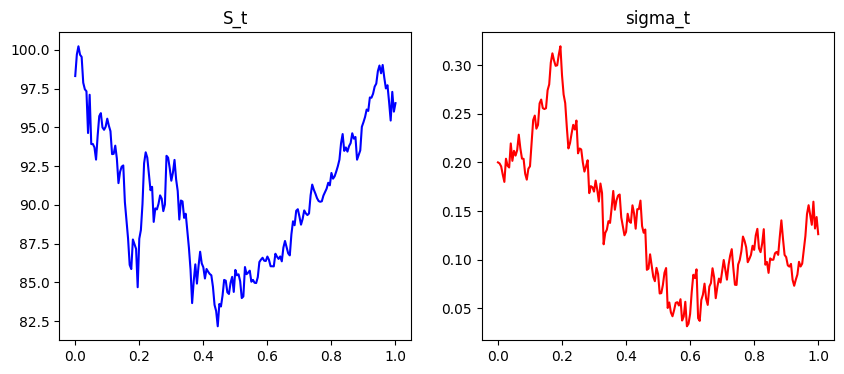

In [8]:
# create a path variable for S and nu
time = numpy.zeros(K+1)
S_t = numpy.zeros(K+1)
nu_t = numpy.zeros(K+1)

# reset the paths by initialising first value
S_t[0] = S_0
nu_t[0] = nu_0

# path number
i=0
for k in range(0,K):
    nu_sqrt=numpy.sqrt(nu_t[k])
    time[k+1] = (k+1)*dt
    S_t[k+1] = S_t[k] + (r-q)*S_t[k]*dt + nu_sqrt*S_t[k]*dW1[i][k]
    nu_t[k+1] = nu_t[k] + kappa_nu*(theta_nu - nu_t[k])*dt + xi_nu*nu_sqrt*dW2[i][k]
    
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(time, S_t, color='blue')
plt.title('S_t')

plt.subplot(1, 2, 2)
plt.plot(time, numpy.sqrt(nu_t), color='red')
plt.title('sigma_t')

The results look reasonable, we can see the negative correlation in effect (stock goes up vol goes down), and stock has higher variance when vol is higher. However there is one worrying feature, $\nu_t$ is getting very close to zero...

# Tasks

- Run the code for path $i=1,2,...$ and plot them on the graph -- do you encounter any problems?
- If $\nu_t<0$ is causing problems, enter a *reflecting* boundary condition to your path calculation, that is
$$\nu^{k+1} =\left\{ \begin{array}{cc}
\nu^k +\kappa(\theta-\nu^k)\Delta t + \xi \sqrt{\nu^k} \Delta W_2 &\text{ if } \quad \nu^k + d\nu^k \geq 0\\
-(\nu^k +\kappa(\theta-\nu^k)\Delta t + \xi \sqrt{\nu^k} \Delta W_2) &\text{ if }\quad \nu^k + d\nu^k < 0
\end{array}\right.
$$  
- Simulate $N$ paths and calculate the average payoff of a call option to estimate the call option value
- Analyse the results for different values of $N$ and $K$, what can you say about the effect of increasing or decreasing each of the numerical parameters.

For the model parameters: $S_0 = 98.31$, $q = 0.01$, $X = 100$, $T = 1$, $r=0.03$, $\kappa = 1.5$, $\theta = 0.06$, $\nu_0 = 0.04$, $\xi = 0.4$ and $\rho = -0.5 $ the analytic result found using a numerical library is $C(S_0,t=0)=8.2623461$.
- What can you say about the errors of your Monte Carlo vs this value?

# Demo 6.2: Path Dependent Options

Assume that the stock price $S_t$ is observed over $K+1$ equally spaced intervals $t_0,t_1,\dots,t_K$ with $t_0=0$ and $t_K=T$. Now let us solve the value of a path dependent option where
we define the underlying asset $A$ to be the average absolute movements in the share price over several periods such that
$$
A = \frac{\sum_{i=1}^K | S(t_i) - S(t_{i-1}) |}{\sqrt{K}} .
$$
Assuming the Black Scholes framework under the risk neutral measure, and we wish to price a call option with payoff 
$$
C(A,S,t=T)=\max(A-X,0).
$$ 

Find the value
$$
C(S_0,t=0) = e^{-rT} E^Q[\max(A-X,0)]
$$
- where $K=20$, strike price $X=30$ and a maturity $T=1$ is one year from now;
- the current stock price is $S_0=104.81$;
- the stock price follows a GBM with $\sigma=0.4$, the interest rate is $r=0.03$.
 

First start by adding some parameters from the question and setting up your random number generator. 

In [9]:
import matplotlib.pyplot as plt
import numpy

rng = numpy.random.default_rng(seed=0)
S_0 = 104.82
sigma=0.4
r=0.03
T=1.
X=30.

K=20
N=1000

Now create a path and check it looks reasonable.

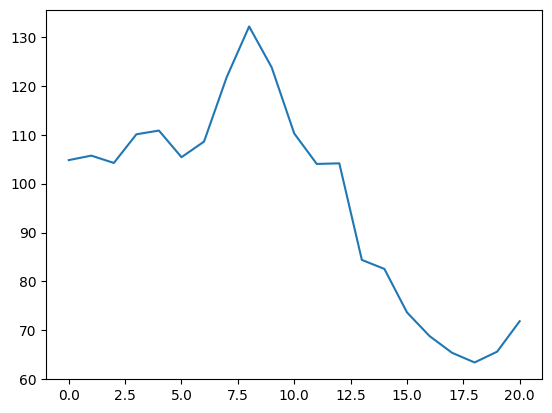

In [10]:
dt = T/K 
dW = rng.normal( 0.0 , numpy.sqrt(dt) , size = (N,K) )

S_t = numpy.zeros(K+1)

# path
i=0
S_t[0] = S_0
for k in range(0,K):
    S_t[k+1] = S_t[k] * numpy.exp((r-0.5*sigma*sigma)*dt+sigma*dW[i][k])

plt.plot(S_t)


Next calculate the value of $A$ from this first path, does it look reasonable?

In [11]:
A=0.0
for k in range(0,K):
    A = A + abs(S_t[k+1] - S_t[k])
A = A/numpy.sqrt(K)
print("A:=",A)

A:= 26.54791524517388


Now put this together and run $N$ paths and take the average of the payoff.


In [12]:
dW = rng.normal( 0.0 , numpy.sqrt(dt) , size = (N,K) )

S_t = numpy.zeros(K+1)

sum=0.0
# run N paths
for i in range(0,N):
    # initialise stock and path variables
    S_t[0] = S_0
    A = 0.0
    # run through path
    for k in range(0,K):
        S_t[k+1] = S_t[k] * numpy.exp((r-0.5*sigma*sigma)*dt+sigma*dW[i][k])
        A = A + abs(S_t[k+1] - S_t[k])
    A = A/numpy.sqrt(K)
    # now calculate payoff on A
    sum = sum + max(A-X,0.0)
print("C:=",sum/N*numpy.exp(-r*T))


C:= 5.994074173708881


# Tasks

- Program your solution into a function
- Analyse the effect of $N$ and $K$ on your results
- There is no obvious analystic solution for the discrete case $K=20$ -- are you able to estimate the error even if you don't know the real solution? 
- Choosing the largest value of $N$ you can feasibly run given the calculation time, state a confidence interval for the result.